- This notebook is to compare some summary statistics between oma releases (number and size of OMA Groups, HOGs, added or removed genomes/taxa levels, number of homoeolog pairs, etc)
- By: Natasha Glover
- Last updated: 
   - Natasha: 13 Aug 2018 
   - Adrian:  12 Jul 2019


# Setup

In [3]:
# Scientific libraries
import numpy as np
#from scipy import stats
import pandas as pd
import tables
import pandas

#basic python libraries
import re
import os

# Pyoma libraries
from pyoma.browser import sanitychecks

# Graphic libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

## Aesthetics

In [31]:
# Extra options
pd.set_option('max_colwidth',200)
pd.options.display.max_rows = 150

#style options
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12.0, 8.0)

#seaborn options
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'}, font_scale=1.5)
sns.set_style('whitegrid')
palette="husl"

## Mounting the oma browser directory

To compare oma browser releases, I use the hdf5 file from each. However, since they are so big (~50 Gb each), I mount the directory on vital-it where they are contained. This is done with sshfs and needs to be mounted before the following analyses. The following command is done from command line:
- sshfs nglover@prd.vital-it.ch:/data/ul/projects/cdessimo/oma-browser ~/oma_mount

## Parameters

TODO: Make it so that it just detects all the databases automatically and then we can run the notebook automatically after each release.

In [4]:
#directory containing the different oma browser releases
oma_browser_dir = os.path.expanduser("~/oma_mount/")

#list of 4 releases (strings) to be compared (only exactly 4 for now)
#note they will be plotted and presented in the order specified in list
releases = ["All.May2016", "All.Mar2017", "All.Dec2017", "All.Jun2018", "All.Dec2018", "All.Jun2019"]

# Running the sanity checks

The following code does all the heavy lifting and uses the sanitychecks2 library from pyoma. Since this involves making many computations, especially from the Entries table in each database, this could take a while to run (~40 minutes).

In [6]:
#import importlib
#importlib.reload(sanitychecks)

#list of sanity (release) objects, each one corresponding to a different release
sanity_sessions = []

for release in releases:
    release_obj = sanitychecks.SanitySession(oma_browser_dir, release)
    sanity_sessions.append(release_obj)

/Users/adriaal/.pyenv/versions/pyoma/lib/python3.5/site-packages/tables/leaf.py:396: PerformanceWarning: The Leaf ``/Protein/_i_Entries/OmaHOG/sorted`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions that are orthogonal (and preferably close) to the *main*
dimension of this leave.  Alternatively, in case you have specified a
very small/large chunksize, you may want to increase/decrease it.
  PerformanceWarning)
/Users/adriaal/.pyenv/versions/pyoma/lib/python3.5/site-packages/tables/leaf.py:396: PerformanceWarning: The Leaf ``/_i_HogLevel/ID/sorted`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions that are orthogonal (and preferably close) to the *main*
dimension o

All.May2016 done
All.Mar2017 done


/Users/adriaal/.pyenv/versions/pyoma/lib/python3.5/site-packages/tables/leaf.py:396: PerformanceWarning: The Leaf ``/_i_HogLevel/Level/sorted`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions that are orthogonal (and preferably close) to the *main*
dimension of this leave.  Alternatively, in case you have specified a
very small/large chunksize, you may want to increase/decrease it.
  PerformanceWarning)


All.Dec2017 done
All.Jun2018 done
All.Dec2018 done
All.Jun2019 done


# Functions

In [7]:
#TODO add these functions to the sanity checks module

In [146]:
def _return_group_object(release_obj, group):
    if group == "hog":
        group_obj = release_obj.all_hogs
    if group == "omagroup":
        group_obj = release_obj.omagroups
    return group_obj

def count_nb_groups(release_obj, group):
    df = pd.DataFrame.from_dict(_return_group_object(release_obj, group), orient='index')
    df['release'] = release_obj.release    
    return df.groupby('release').size().item()

def get_nb_genes_per_group_df(release_obj, group):
    df = pd.DataFrame.from_dict(_return_group_object(release_obj, group), orient='index')
    df['release'] = release_obj.release
    df.reset_index(inplace=True) 
    df.rename({0:"nb_genes", "index":group}, inplace=True, axis=1)    
    return df

def sort_df_by_release(df):
    df.release = df.release.astype("category")
    df.release.cat.set_categories(releases, inplace=True)
    df = df.sort_values("release")
    return df

def cum_bin_cnts_by_release(df, column, bin_width=10):
    """return the cumulative counts of the number of groups that have
    at least the size of the bin value"""
    bins = np.arange(0, max(df[column])+bin_width, bin_width)
    dfq = pandas.DataFrame({rel: np.histogram(df[df['release']==rel][column], bins)[0] 
                            for rel in df['release'].unique()})
    cum = dfq.iloc[::-1].cumsum()
    cum['bin'] = bins[:-1][::-1]
    cum['lab'] = np.array(list(">{}".format(z) for z in bins[:-1]))[::-1]
    return cum

def make_countplot_by_release(df, releases, title="Don't forget a title"):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
    ax = sns.countplot(x="release", data=df, order=releases, palette="husl")
    ax.set_title(title)
    return ax

def get_differences_in_genomes_or_taxa(df, old_release, new_release, genomes_or_taxa):
    '''old_release and new_release should be sanity session objects'''
    
    if genomes_or_taxa == "genomes":
        added = list(set(new_release.species) - set(old_release.species))
        removed = list(set(old_release.species) - set(new_release.species))
        
    if genomes_or_taxa == "taxa":
        added = list(set(new_release.all_hog_lvls) - set(old_release.all_hog_lvls))
        removed = list(set(old_release.all_hog_lvls) - set(new_release.all_hog_lvls))
        added = [x.decode("utf-8") for x in added]
        removed = [x.decode("utf-8") for x in removed]
    res = {'added':added, 'removed': removed}
    return res

def decode_column_in_df(df, column_to_decode):
    df[column_to_decode] = df.apply(lambda x: x[column_to_decode].decode("utf-8"), axis=1)
    return df

def make_boxplot_by_release(df, releases, column_to_plot, title="Don't forget a title"):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,4))
    sns.boxplot(x="release", y=column_to_plot, data=df, ax=ax[0], palette=palette, order=releases)
    ax[0].set_title("Outliers shown")
    sns.boxplot(x="release", y=column_to_plot, data=df, ax=ax[1], showfliers=False, palette=palette, order=releases)
    ax[1].set_title("No outliers shown")
    plt.suptitle(title)
    plt.subplots_adjust(top=0.75)
    plt.show()
    
def make_cumbiggerthan_plot_by_release(cum_df, releases, title="Don't forget a title"):
    pal = matplotlib.colors.ListedColormap(sns.color_palette(palette, len(releases)))
    fig, ax = plt.subplots()
    for num, rel in enumerate(releases):
        plt.plot('bin', rel, data=cum_df, marker='', color=pal(num), linewidth=2.4, alpha=0.9, label=rel)
    plt.semilogy()
    xstep = len(cum_df)//20
    if cum_df['bin'][0]>0:
        xstep = -xstep
    plt.xticks(cum_df['bin'][::xstep], fontsize=15, rotation=45)
    plt.legend()
    plt.xlabel("Size")
    plt.ylabel('Cumulative counts')
    plt.title(title, fontsize=15)
    plt.show()
    
def get_prop_with_n_genes(df, releases, nb_genes=2):
    '''get number of groups per release
    param releases is the list of string releases'''
    df1 = df.groupby('release').size().reset_index()
    df1.rename({0:'total_nb_groups'}, axis=1, inplace=True)

    #get groups with n genes
    df2 = df[df['nb_genes']==nb_genes].groupby('release').size().reset_index()
    df2.rename({0:'nb_groups_with_'+str(nb_genes)+'_genes'}, axis=1, inplace=True)
    
    #get proportion
    df3 = pd.merge(left=df1, right=df2, how="left", on="release")
    df3['prop_groups_'+str(nb_genes)+'_genes'] = df3['nb_groups_with_'+str(nb_genes)+'_genes']/ df3['total_nb_groups']
    df3.set_index("release", inplace=True)
    df3 = df3.reindex(releases)
    df3.reset_index(level=0, inplace=True)
    return df3

def get_total_nb_groups(df):
    df = df.groupby('release').size().reset_index()
    df.rename({0:"nb_genomes"}, axis=1, inplace=True)
    df = sort_df_by_release(df) 
    return df

def get_summary_stats(df, column_to_summarize):
    df= df[['release',column_to_summarize]].groupby('release').describe().reset_index()
    df.columns = df.columns.droplevel()
    df = df.rename({'':'release'}, axis=1)
    df = sort_df_by_release(df)
    return df

def plot_proportions_of_groups_with_n_genes(low_genes_df, list_of_columns_to_plot,\
                                            title="Don't forget a title", rename_cols=False):
    
    if rename_cols==True:
        low_genes_df = rename_proportion_columns(low_genes_df)
        list_of_columns_to_plot = rename_proportion_columns(low_genes_df).columns[1:5]
        
    
    #melt dataframe
    melted_low_genes_df = pd.melt(low_genes_df, id_vars=['release'], \
                                  value_vars=list_of_columns_to_plot)
    melted_low_genes_df.rename({"variable": "nb genes in group", "value": "proportion of groups"}, \
                               axis=1, inplace=True)
    
    #make plot
    fig, ax= plt.subplots(figsize=(10,10))
    sns.pointplot(x="release", y="proportion of groups", hue="nb genes in group", data=melted_low_genes_df, \
                 palette=palette)
    #plt.legend(loc="upper right")
    plt.ylim(0,.7)
    plt.title(title)
    plt.show()

def get_low_genes_df(df, releases, list_of_gene_numbers=[2,3,4,5]):
    '''makes a dataframe with proportion of genes with n number for each release.'''
    low_genes_df = pd.DataFrame.from_items([('release', releases)])

    for i in range(list_of_gene_numbers[0],list_of_gene_numbers[-1]+1):
        tmp_df = pd.DataFrame(get_prop_with_n_genes(df, releases, i))
        low_genes_df = pd.merge(left=low_genes_df, right=tmp_df[['release',tmp_df.columns[-1]]],\
                                how="left", on="release")

    low_genes_df['total_nb_groups'] = get_prop_with_n_genes(df, releases, 2)['total_nb_groups']
    return low_genes_df

def rename_proportion_columns(df):
    columns = df.columns
    new_columns = {}
    for column in columns:
        if "prop_groups" in column:
            matchObj = re.match(r'prop_groups_(.*)_genes', column)
            try:
                new_column = matchObj.group(1)
                new_columns[column] = new_column
            except:
                print("no match")
    
    df = df.rename(new_columns, axis=1)
    return df


# Compare Genomes

In [9]:
#get genome dataframe
genome_df = pd.DataFrame()
for release in sanity_sessions:
    tmp_df = pd.DataFrame.from_items([('genomes', release.species)])
    tmp_df['release'] = release.release
    genome_df = genome_df.append(tmp_df)

/Users/adriaal/.pyenv/versions/pyoma/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.


## Nb of genomes

In [10]:
get_total_nb_groups(genome_df)

,release,nb_genomes
5,All.May2016,2024
4,All.Mar2017,2085
0,All.Dec2017,2103
2,All.Jun2018,2167
1,All.Dec2018,2198
3,All.Jun2019,2288


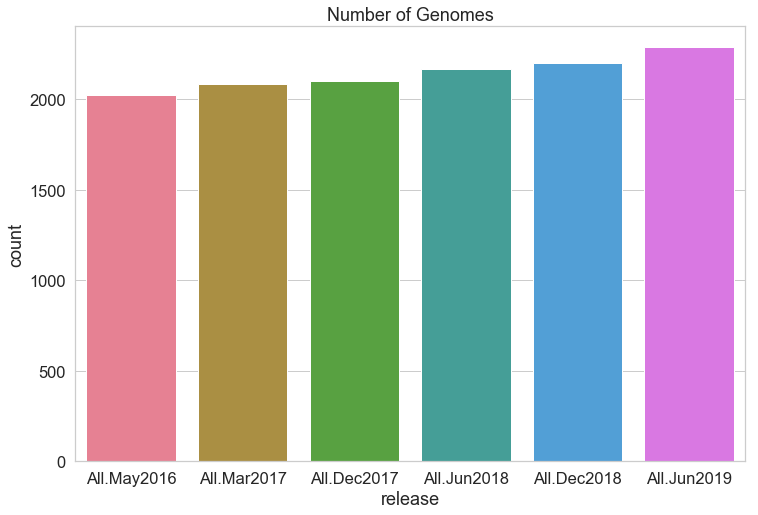

In [23]:
make_countplot_by_release(genome_df, releases, "Number of Genomes")

## Genomes added

In [15]:
#latest genomes added
genome1_df = pd.DataFrame(sanity_sessions[-2].genome_table.read())
genome1_df = decode_column_in_df(genome1_df, "UniProtSpeciesCode")
genome2_df = pd.DataFrame(sanity_sessions[-1].genome_table.read())
genome2_df = decode_column_in_df(genome2_df, "UniProtSpeciesCode")

diff = get_differences_in_genomes_or_taxa(genome_df, sanity_sessions[-2], sanity_sessions[-1], "genomes")
genome2_df.loc[genome2_df['UniProtSpeciesCode'].isin(diff['added'])] 

,NCBITaxonId,UniProtSpeciesCode,TotEntries,TotAA,EntryOff,SciName,CommonName,SynName,Release,Url,Source,Date,IsPolyploid
193,502558,EEGSY,2680,914273,455233,b'Eggerthella sp. (strain YY7918)',b'',b'',b'Ensembl Bacteria 41; ASM27028v1',b'http://bacteria.ensembl.org/Eggerthella_sp._YY7918',b'ftp://ftp.ensemblgenomes.org/pub/bacteria/release-41/embl/eggerthella_sp._yy7918',1546815600,False
213,525263,CORLD,2371,696470,504126,b'Corynebacterium lipophiloflavum (strain DSM 44291 / CCUG 37336)',b'',b'',b'Ensembl Bacteria 41; ASM15963v1',b'http://bacteria.ensembl.org/Corynebacterium_lipophiloflavum_DSM_44291',b'ftp://ftp.ensemblgenomes.org/pub/bacteria/release-41/embl/corynebacterium_lipophiloflavum_dsm_44291',1546815600,False
229,1778,MYCGO,6409,2129672,557885,b'Mycobacterium gordonae',b'',b'',b'Ensembl Bacteria 41; ASM141795v2',b'http://bacteria.ensembl.org/Mycobacterium_gordonae',b'ftp://ftp.ensemblgenomes.org/pub/bacteria/release-41/embl/mycobacterium_gordonae',1546815600,False
230,1768,MYCKA,5037,1633582,564294,b'Mycobacterium kansasii',b'',b'',b'Ensembl Bacteria 41; Mkan_typeIV_1.0',b'http://bacteria.ensembl.org/Mycobacterium_kansasii_(GCA_001632895)',b'ftp://ftp.ensemblgenomes.org/pub/bacteria/release-41/embl/mycobacterium_kansasii_(gca_001632895)',1542236400,False
234,29313,MYCSH,4327,1415340,580131,b'Mycobacterium shimoidei',b'',b'',b'Ensembl Bacteria 41; ASM172244v1',b'http://bacteria.ensembl.org/Mycobacterium_shimoidei',b'ftp://ftp.ensemblgenomes.org/pub/bacteria/release-41/embl/mycobacterium_shimoidei',1542236400,False
250,1774,MYCCH,4489,1416154,648435,b'Mycobacterium chelonae',b'',b'',b'Ensembl Bacteria 41; ASM97180v1',b'http://bacteria.ensembl.org/Mycobacterium_chelonae',b'ftp://ftp.ensemblgenomes.org/pub/bacteria/release-41/embl/mycobacterium_chelonae',1542236400,False
255,1078020,MYCT3,4614,1469997,674893,b'Mycobacterium thermoresistibile (strain ATCC 19527 / DSM 44167 / CIP 105390 / JCM 6362 / NCTC 10409 / 316)',b'',b'',b'Ensembl Bacteria 41; ASM23458v1',b'http://bacteria.ensembl.org/Mycobacterium_thermoresistibile_ATCC_19527',b'ftp://ftp.ensemblgenomes.org/pub/bacteria/release-41/embl/mycobacterium_thermoresistibile_atcc_19527',1546815600,False
260,1122247,MYCHD,4959,1513761,701898,b'Mycobacterium hassiacum (strain DSM 44199 / CIP 105218 / JCM 12690 / 3849)',b'',b'',b'Ensembl Bacteria 41; ASM30037v1',b'http://bacteria.ensembl.org/Mycobacterium_hassiacum_DSM_44199',b'ftp://ftp.ensemblgenomes.org/pub/bacteria/release-41/embl/mycobacterium_hassiacum_dsm_44199',1546815600,False
286,710696,INTC7,3563,1199961,833089,b'Intrasporangium calvum (strain ATCC 23552 / DSM 43043 / JCM 3097 / NBRC 12989 / 7 KIP)',b'',b'',b'Ensembl Bacteria 41; ASM18468v1',b'http://bacteria.ensembl.org/Intrasporangium_calvum_DSM_43043',b'ftp://ftp.ensemblgenomes.org/pub/bacteria/release-41/embl/intrasporangium_calvum_dsm_43043',1546815600,False
309,1869,ACTUT,7339,2300858,912190,b'Actinoplanes utahensis',b'',b'',b'Ensembl Bacteria 41; ASM78598v1',b'http://bacteria.ensembl.org/Actinoplanes_utahensis',b'ftp://ftp.ensemblgenomes.org/pub/bacteria/release-41/embl/actinoplanes_utahensis',1546815600,False


In [24]:
print("In total there were {:d} new genomes in the latest release".format(len(diff['added'])))

In total there were 90 new genomes in the latest release


## Genomes removed

In [25]:
genome1_df.loc[genome1_df['UniProtSpeciesCode'].isin(diff['removed'])] 

,NCBITaxonId,UniProtSpeciesCode,TotEntries,TotAA,EntryOff,SciName,CommonName,SynName,Release,Url,Source,Date,IsPolyploid


In [26]:
print("In total there were {:d} removed genomes in the latest release".format(len(diff['removed'])))

In total there were 0 removed genomes in the latest release


# Compare number of proteins

In [27]:
#note this include ASVs
df = pd.DataFrame()
for release in sanity_sessions:
    df = df.append({'release': release.release, "nb_entries": release.entries_table.attrs.NROWS}, ignore_index=True)
    
sort_df_by_release(df)

,nb_entries,release
0,10455627.0,All.May2016
1,11404511.0,All.Mar2017
2,11624503.0,All.Dec2017
3,12691751.0,All.Jun2018
4,13149446.0,All.Dec2018
5,14674630.0,All.Jun2019


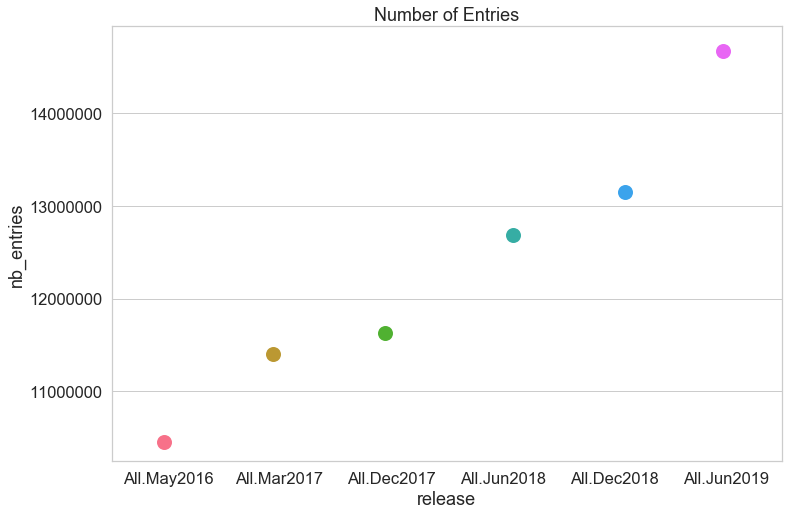

In [32]:
sns.stripplot(x="release", y="nb_entries",data=df, order=releases, size=15, palette="husl")
plt.title("Number of Entries")
plt.ticklabel_format(style='plain', axis='y')

# Compare OMA Groups

In [33]:
#get omagroups df
omagroups_df = pd.DataFrame()
for release in sanity_sessions:
    tmp_df = get_nb_genes_per_group_df(release, "omagroup")
    omagroups_df = omagroups_df.append(tmp_df, ignore_index=True)

## Nb of omagroups

In [34]:
#total number of omagroups
get_total_nb_groups(omagroups_df)

,release,nb_genomes
5,All.May2016,1034997
4,All.Mar2017,779787
0,All.Dec2017,798760
2,All.Jun2018,842789
1,All.Dec2018,866647
3,All.Jun2019,918638


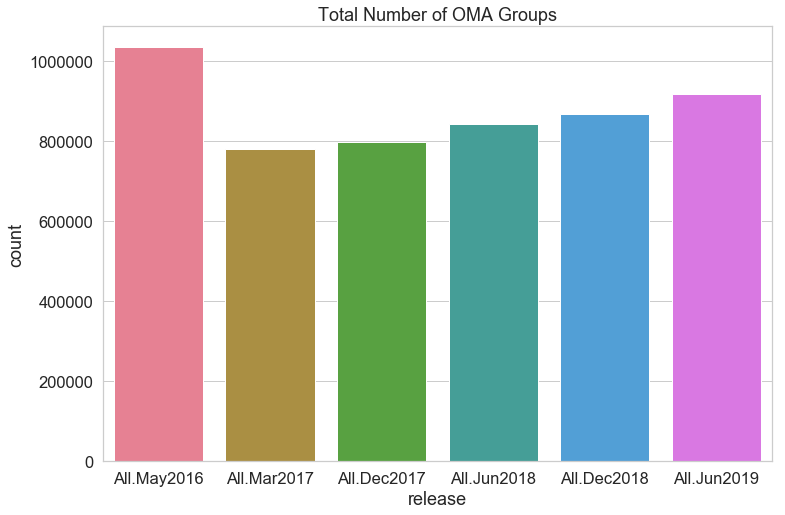

In [35]:
make_countplot_by_release(omagroups_df, releases, title="Total Number of OMA Groups")

## Nb genes per OMA Groups summary stats

In [62]:
get_summary_stats(omagroups_df, "nb_genes")

,release,count,mean,std,min,25%,50%,75%,max
5,All.May2016,1034997.0,8.283003,27.151089,2.0,2.0,3.0,6.0,1720.0
4,All.Mar2017,779787.0,11.619314,48.575176,2.0,2.0,3.0,7.0,2010.0
0,All.Dec2017,798760.0,11.539356,48.279524,2.0,2.0,3.0,7.0,2023.0
2,All.Jun2018,842789.0,11.594424,48.289840,2.0,2.0,3.0,7.0,2079.0
1,All.Dec2018,866647.0,11.575333,48.180143,2.0,2.0,3.0,7.0,2109.0
3,All.Jun2019,918638.0,11.943227,49.072848,2.0,2.0,3.0,7.0,2189.0


## Plot distributions

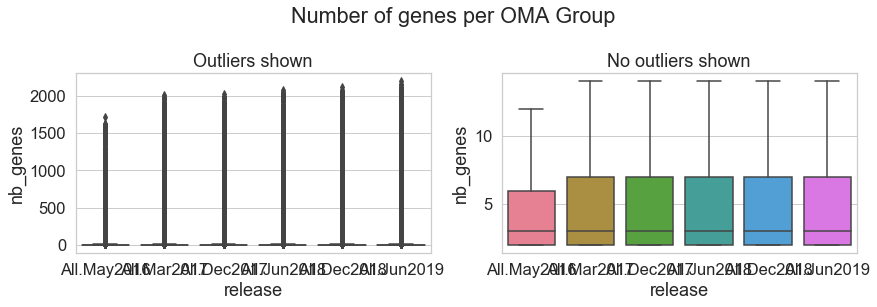

In [66]:
make_boxplot_by_release(omagroups_df, releases, "nb_genes","Number of genes per OMA Group")

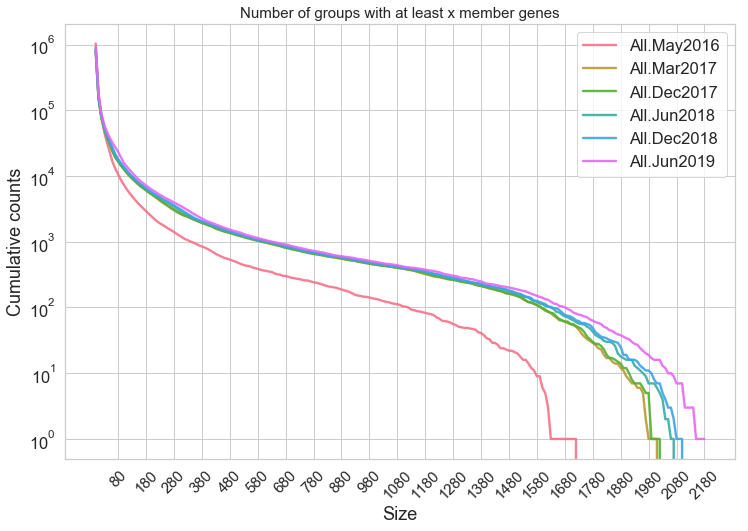

In [147]:
cum = cum_bin_cnts_by_release(omagroups_df, 'nb_genes')
make_cumbiggerthan_plot_by_release(cum, releases, 'Number of groups with at least x member genes')

## Groups with low numbers of genes

In [38]:
low_genes_df = get_low_genes_df(omagroups_df, releases)
low_genes_df

/Users/adriaal/.pyenv/versions/pyoma/lib/python3.5/site-packages/ipykernel/__main__.py:113: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.


,release,prop_groups_2_genes,prop_groups_3_genes,prop_groups_4_genes,prop_groups_5_genes,total_nb_groups
0,All.May2016,0.399239,0.163242,0.094130,0.061720,1034997
1,All.Mar2017,0.434266,0.121175,0.074918,0.062639,779787
2,All.Dec2017,0.428975,0.124880,0.075933,0.061164,798760
3,All.Jun2018,0.429863,0.121433,0.076717,0.061436,842789
4,All.Dec2018,0.421962,0.127163,0.076493,0.061356,866647
5,All.Jun2019,0.421934,0.126622,0.076070,0.061001,918638


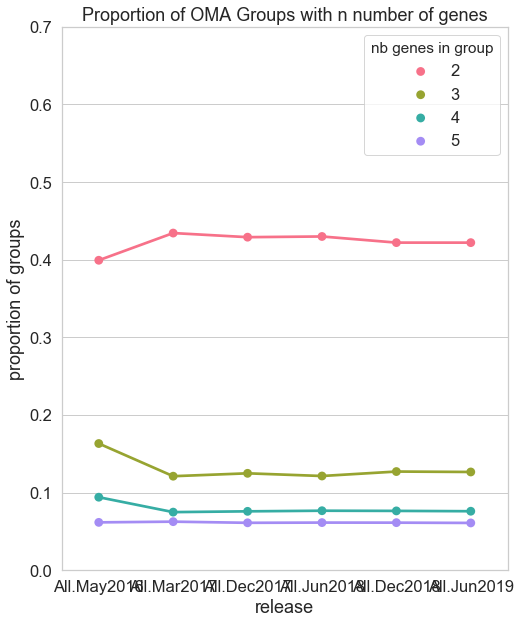

In [39]:
low_genes_df.rename({'prop_groups_2_genes':"2",'prop_groups_3_genes':"3",\
                     'prop_groups_4_genes':"4",'prop_groups_5_genes':"5"}, axis=1, inplace=True)


plot_proportions_of_groups_with_n_genes(low_genes_df, low_genes_df.columns[1:5],\
                                        "Proportion of OMA Groups with n number of genes")

# Compare HOGs (subhogs)

In [40]:
#get hog df
hog_df = pd.DataFrame()
for release in sanity_sessions:
    tmp_df = get_nb_genes_per_group_df(release, "hog")
    hog_df = hog_df.append(tmp_df, ignore_index=True)

## Nb of hogs

In [41]:
#total number of hogs
get_total_nb_groups(hog_df)

,release,nb_genomes
5,All.May2016,2252466
4,All.Mar2017,2676228
0,All.Dec2017,2717565
2,All.Jun2018,2882980
1,All.Dec2018,2968201
3,All.Jun2019,3196844


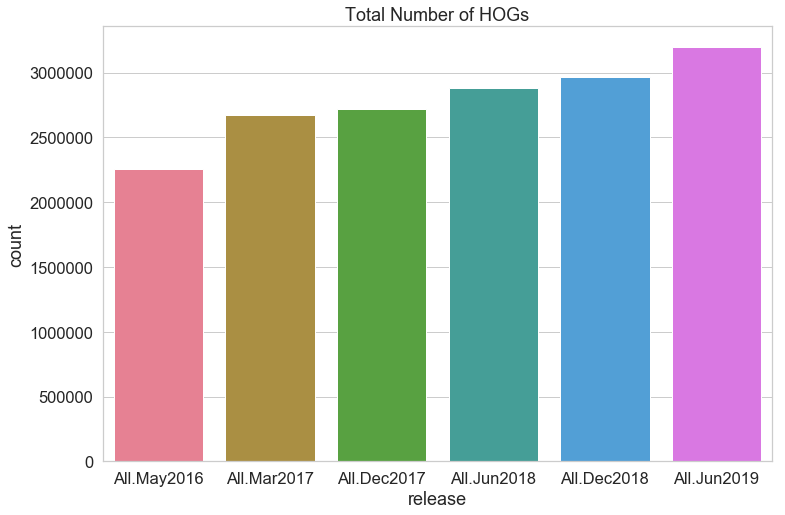

In [42]:
make_countplot_by_release(hog_df, releases, title="Total Number of HOGs")

## Nb genes per HOG summary stats

In [43]:
get_summary_stats(hog_df, "nb_genes")

,release,count,mean,std,min,25%,50%,75%,max
5,All.May2016,2252466.0,3.768766,15.285949,1.0,1.0,1.0,2.0,1737.0
4,All.Mar2017,2676228.0,3.528828,16.305082,1.0,1.0,1.0,2.0,1744.0
0,All.Dec2017,2717565.0,3.534553,16.208430,1.0,1.0,1.0,2.0,1746.0
2,All.Jun2018,2882980.0,3.536418,16.198242,1.0,1.0,1.0,2.0,1775.0
1,All.Dec2018,2968201.0,3.527766,16.053698,1.0,1.0,1.0,2.0,1782.0
3,All.Jun2019,3196844.0,3.576151,16.047741,1.0,1.0,1.0,2.0,1809.0


## Plot distributions

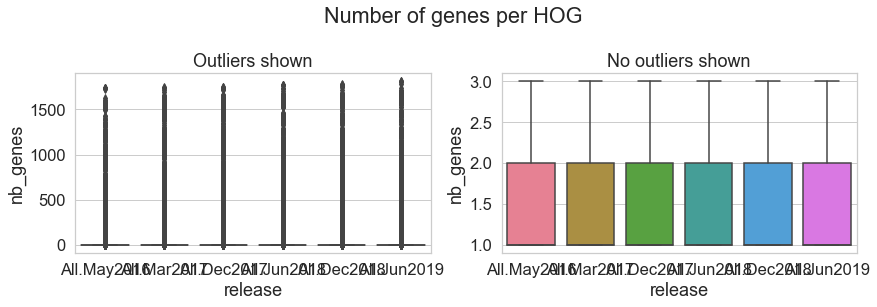

In [44]:
make_boxplot_by_release(hog_df, releases, "nb_genes", "Number of genes per HOG")

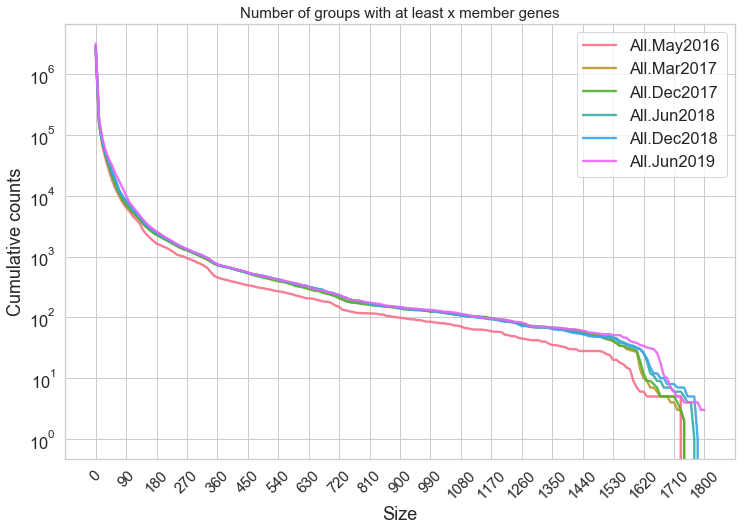

In [148]:
cum_hog = cum_bin_cnts_by_release(hog_df, 'nb_genes')
make_cumbiggerthan_plot_by_release(cum_hog, releases, 'Number of groups with at least x member genes')

## HOGs with low numbers

In [45]:
low_genes_df = get_low_genes_df(hog_df, releases, [1,2,3,4])
low_genes_df

/Users/adriaal/.pyenv/versions/pyoma/lib/python3.5/site-packages/ipykernel/__main__.py:113: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.


,release,prop_groups_1_genes,prop_groups_2_genes,prop_groups_3_genes,prop_groups_4_genes,total_nb_groups
0,All.May2016,0.566203,0.190329,0.066491,0.037233,2252466
1,All.Mar2017,0.588565,0.202079,0.062200,0.031039,2676228
2,All.Dec2017,0.585328,0.201484,0.065206,0.031485,2717565
3,All.Jun2018,0.594853,0.199572,0.058460,0.031824,2882980
4,All.Dec2018,0.597255,0.193392,0.061454,0.032431,2968201
5,All.Jun2019,0.600590,0.191192,0.061218,0.032921,3196844


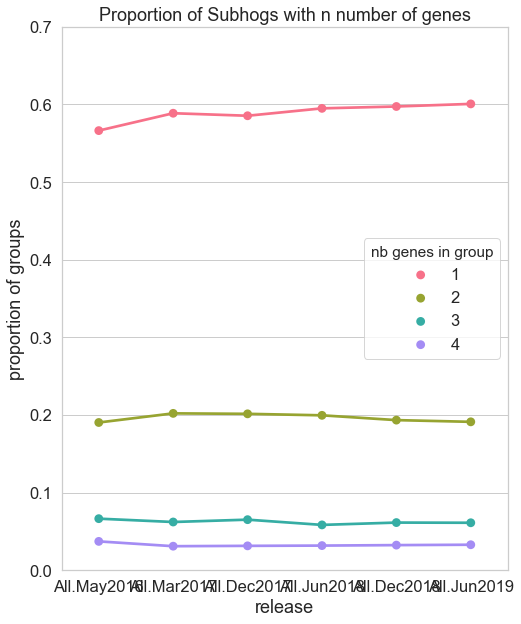

In [46]:
plot_proportions_of_groups_with_n_genes(low_genes_df, low_genes_df.columns[1:5],\
                                        "Proportion of Subhogs with n number of genes",\
                                       rename_cols=True)

# Compare families (root hogs)

In [47]:
hog_df['fam'] = hog_df.apply(lambda x: int(x['hog'][4:11]), axis=1)
grouped = hog_df.groupby(['release','fam'])
fam_df = grouped.sum().reset_index()

## Nb of families

In [48]:
#total number of families
get_total_nb_groups(fam_df)

,release,nb_genomes
5,All.May2016,432519
4,All.Mar2017,589223
0,All.Dec2017,603285
2,All.Jun2018,614588
1,All.Dec2018,628448
3,All.Jun2019,685790


## Nb genes per fam summary stats

In [49]:
get_summary_stats(fam_df, "nb_genes")

,release,count,mean,std,min,25%,50%,75%,max
5,All.May2016,432519.0,19.626925,123.654094,2.0,2.0,3.0,8.0,17256.0
4,All.Mar2017,589223.0,16.027798,376.403707,2.0,2.0,3.0,6.0,217038.0
0,All.Dec2017,603285.0,15.921792,377.489090,2.0,2.0,3.0,6.0,220984.0
2,All.Jun2018,614588.0,16.589034,208.710918,2.0,2.0,3.0,7.0,116081.0
1,All.Dec2018,628448.0,16.661872,222.774060,2.0,2.0,3.0,7.0,131656.0
3,All.Jun2019,685790.0,16.670405,218.451772,2.0,2.0,3.0,7.0,135172.0


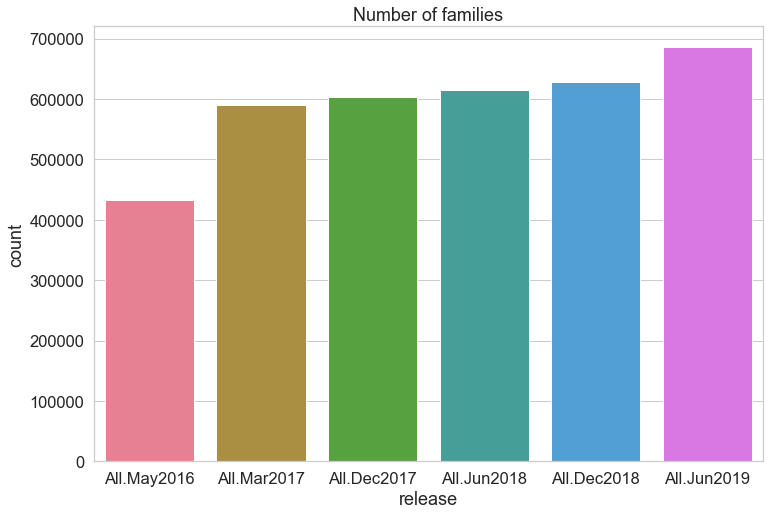

In [50]:
make_countplot_by_release(fam_df, releases, title="Number of families")

## Plot distributions

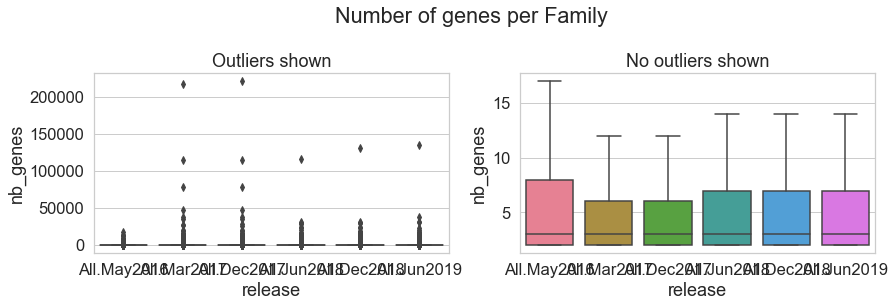

In [51]:
make_boxplot_by_release(fam_df, releases, "nb_genes","Number of genes per Family")

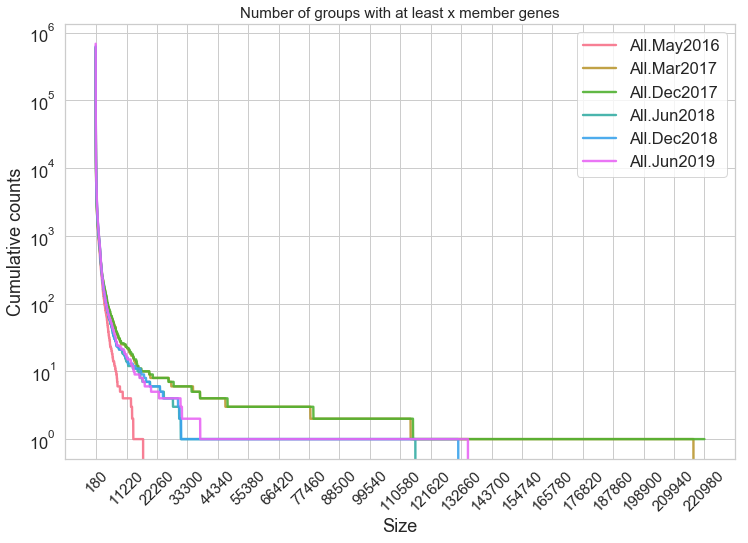

In [150]:
cum_fam = cum_bin_cnts_by_release(fam_df, 'nb_genes')
make_cumbiggerthan_plot_by_release(cum_fam, releases, 'Number of groups with at least x member genes')

## Families with low numbers

In [53]:
low_genes_df = get_low_genes_df(fam_df, releases, [2,3,4,5])
low_genes_df

/Users/adriaal/.pyenv/versions/pyoma/lib/python3.5/site-packages/ipykernel/__main__.py:113: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.


,release,prop_groups_2_genes,prop_groups_3_genes,prop_groups_4_genes,prop_groups_5_genes,total_nb_groups
0,All.May2016,0.426314,0.132864,0.077569,0.053632,432519
1,All.Mar2017,0.455921,0.158453,0.078602,0.050998,589223
2,All.Dec2017,0.448829,0.163876,0.081030,0.046845,603285
3,All.Jun2018,0.448442,0.127899,0.083209,0.047240,614588
4,All.Dec2018,0.436074,0.135796,0.083248,0.047592,628448
5,All.Jun2019,0.429070,0.134952,0.084349,0.057566,685790


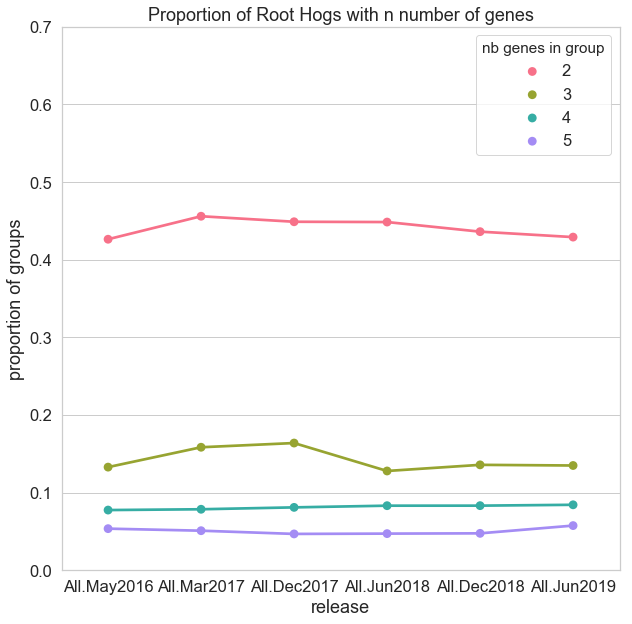

In [54]:
plot_proportions_of_groups_with_n_genes(low_genes_df, low_genes_df.columns[1:5],\
                                        "Proportion of Root Hogs with n number of genes",\
                                       rename_cols=True)

# Compare at different taxa levels

In [55]:
tax_df = pd.DataFrame()
for release in sanity_sessions:
    tmp_df = pd.DataFrame.from_dict(release.all_hog_lvls, orient="index")
    tmp_df = tmp_df.rename({0:'nb_hogs'}, axis=1)
    tmp_df = tmp_df.reset_index()
    tmp_df['release'] = release.release
    tax_df = tax_df.append(tmp_df)

tax_df.rename({'index':'taxa'}, axis=1, inplace=True)
tax_df['taxa'] = tax_df.apply(lambda x: x['taxa'].decode("utf-8"), axis=1)

## Nb of taxa levels

In [56]:
get_total_nb_groups(tax_df)

,release,nb_genomes
5,All.May2016,5458
4,All.Mar2017,2920
0,All.Dec2017,2956
2,All.Jun2018,3048
1,All.Dec2018,3104
3,All.Jun2019,3236


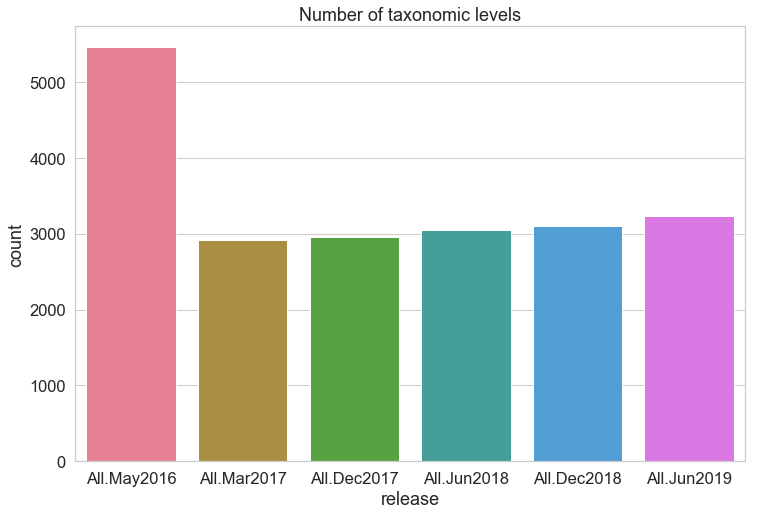

In [57]:
#number of taxa
make_countplot_by_release(tax_df, releases, title="Number of taxonomic levels")

## Nb hogs per taxa summary stats

In [58]:
#number of hogs per taxonomic level summary stats
get_summary_stats(tax_df, 'nb_hogs')

,release,count,mean,std,min,25%,50%,75%,max
5,All.May2016,5458.0,5243.927812,5774.193137,4.0,1943.00,3198.5,5666.00,67352.0
4,All.Mar2017,2920.0,5982.007877,7857.964114,69.0,2062.50,3533.0,5878.25,90253.0
0,All.Dec2017,2956.0,6009.267591,7858.234757,69.0,2078.75,3546.5,6002.50,90288.0
2,All.Jun2018,3048.0,6205.886483,8190.807309,69.0,2089.75,3597.0,6126.25,90818.0
1,All.Dec2018,3104.0,6317.118557,8297.162774,70.0,2101.50,3640.0,6321.50,102147.0
3,All.Jun2019,3236.0,6677.863721,8733.239141,92.0,2133.75,3758.5,6786.75,102163.0


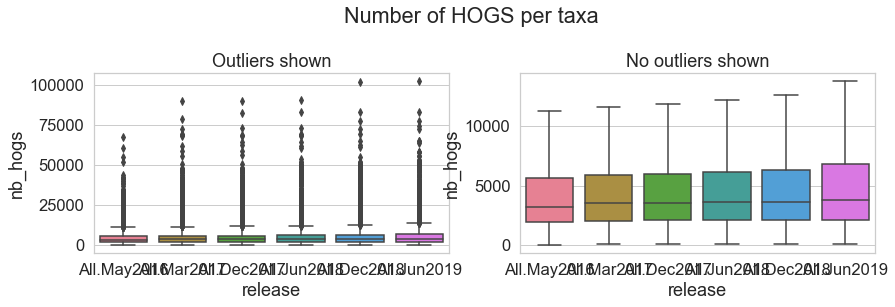

In [59]:
#distribution of number of hogs per taxa level
make_boxplot_by_release(tax_df, releases, 'nb_hogs', "Number of HOGS per taxa")

## Taxa added

In [60]:
old_release = sanity_sessions[-2]
new_release = sanity_sessions[-1]
get_differences_in_genomes_or_taxa(tax_df, old_release, new_release, "taxa")['added']

['Ursidae',
 'Synechococcus elongatus',
 'Ustilaginomycotina',
 'Prevotella dentalis (strain ATCC 49559 / DSM 3688 / JCM 13448 / NCTC 12043 / ES 2772)',
 'Trypanosoma congolense (strain IL3000)',
 'Kitasatospora aureofaciens',
 'Platyrrhini',
 'Corynebacterium lipophiloflavum (strain DSM 44291 / CCUG 37336)',
 'Macaca',
 'Cavia',
 'Ursus',
 'Mandrillus leucophaeus',
 'Rhinopithecus roxellana',
 'Actinoplanes utahensis',
 'Synechococcus sp. (strain ATCC 27167 / PCC 6312)',
 'Cyberlindnera',
 'Hexapoda',
 'Wallemia ichthyophaga (strain EXF-994 / CBS 113033)',
 'Mycobacterium gordonae',
 'Lepidosauria',
 'Nosema ceranae (strain BRL01)',
 'Eutypa lata (strain UCR-EL1)',
 'Eggerthella sp. (strain YY7918)',
 'Beauveria bassiana',
 'Porphyromonas cangingivalis',
 'Amphiprion ocellaris',
 'Propithecus coquereli',
 'Oryzias',
 'Flavobacterium sp. (strain CF136)',
 'Cryptodira',
 'Cyprinodontoidei',
 'Trypanosoma',
 'Trichoderma harzianum',
 'Arthroderma benhamiae (strain ATCC MYA-4681 / CBS 112

## Taxa removed

In [61]:
get_differences_in_genomes_or_taxa(tax_df, old_release, new_release, "taxa")['removed']

[]

## Taxa with 2 genes in family

The following analysis uses the latest release.

In [301]:
#get families with 2 genes
families_2_genes = fam_df[(fam_df['nb_genes']==2) & (fam_df['release']==releases[3])]['fam']

#open up latest h5 file
h5file = tables.open_file(oma_browser_dir+"/"+releases[3]+"/data/OmaServer.h5", "r")

#read hog level table and make df
hog_level_df = pd.DataFrame(h5file.root.HogLevel.read())

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tables/leaf.py:396: PerformanceWarning: The Leaf ``/_i_HogLevel/ID/sorted`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions that are orthogonal (and preferably close) to the *main*
dimension of this leave.  Alternatively, in case you have specified a
very small/large chunksize, you may want to increase/decrease it.
  PerformanceWarning)
/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tables/leaf.py:396: PerformanceWarning: The Leaf ``/_i_HogLevel/Level/sorted`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions 

In [322]:
#get rows with rootlevel taxa matching list of families w/ 2 genes
taxa_2_genes_at_root_df = hog_level_df[hog_level_df['Fam'].isin(families_2_genes)].\
                                                            drop_duplicates(subset='Fam').\
                                                            groupby('Level').\
                                                            size().\
                                                            reset_index().\
                                                            sort_values(0, ascending=False)
taxa_2_genes_at_root_df = taxa_2_genes_at_root_df.rename({0:"nb_families"}, axis=1)
taxa_2_genes_at_root_df = decode_column_in_df(taxa_2_genes_at_root_df, "Level")

In [331]:
#top 20 taxa with the most families consisting of 2 genes
taxa_2_genes_at_root_df[:20]

,Level,nb_families
661,Puccinia graminis,14508
154,Capitella,12189
121,Brassica,9013
499,Musa acuminata,8680
306,Eukaryota,6712
572,Oryza,5536
613,Phaeosphaeria nodorum,4888
107,Bilateria,4334
89,Bacteria,3838
719,Sarcocystidae,3345
